# Libs

In [295]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
from typing import Any, List, Dict, Tuple
from sklearn.metrics import f1_score, accuracy_score
import seaborn as sns
from tqdm import tqdm

# Functions and classes

In [296]:
def percentile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'percentile_{:02.0f}'.format(n*100)
    return percentile_

In [298]:
class LazyClassifierFCA:
    def __init__(self):
        self.X_train = None
        self.y_train = None

    def fit(self, X_train: pd.DataFrame, y_train: pd.Series) -> None:
        self.X_train = X_train
        self.y_train = y_train
        
    def classify_sample(self, sample: pd.Series, verbose=0) -> Any:
        X_train_positive = self.X_train[y_train == 1]
        X_train_negative = self.X_train[y_train == 0]
        
        positive_classifiers = 0
        negative_classifiers = 0
        
        def is_positive_classifier(intersection):
            # Find samples in X_train_positive that contain the intersection
            num_positive = ((X_train_positive | ~intersection) == True).all(axis=1).sum()
            num_negative = ((X_train_negative | ~intersection) == True).all(axis=1).sum()
            return num_negative == 0 and num_positive > 1
        
        def is_negative_classifier(intersection):
            num_positive = ((X_train_positive | ~intersection) == True).all(axis=1).sum()
            num_negative = ((X_train_negative | ~intersection) == True).all(axis=1).sum()
            return num_positive == 0 and num_negative > 1
        
        # Check for positive classifiers by intersecting sample with each positive object
        for _, pos_sample in X_train_positive.iterrows():
            intersection = sample & pos_sample
            if is_positive_classifier(intersection):
                positive_classifiers += 1

        # Check for negative classifiers by intersecting sample with each negative object
        for _, neg_sample in X_train_negative.iterrows():
            intersection = sample & neg_sample
            if is_negative_classifier(intersection):
                negative_classifiers += 1

        # Determine the class based on the number of classifiers
        if positive_classifiers > negative_classifiers:
            if verbose == 1:
                print(f"sample {sample.name} is classified as 1, {positive_classifiers=}, {negative_classifiers=}")
            return 1  # Predict positive
            
        elif negative_classifiers > positive_classifiers:
            if verbose == 1:
                print(f"sample {sample.name} is classified as 0, {positive_classifiers=}, {negative_classifiers=}")
            return 0  # Predict negative

        elif negative_classifiers == positive_classifiers:
            return 1  # or 0, depending on the choice
        else:
            if verbose == 1:
                # If equal, you can decide on a rule, like defaulting to 0 or 1, or returning 'undetermined'
                print(f"sample {sample.name} is classified as 1, default, {positive_classifiers=}, {negative_classifiers=}")
        
            return 1  # or 0, depending on the choice


    def predict(self, X_test: pd.DataFrame, verbose=0) -> List[Any]:
        # List to store predictions for each test sample
        predictions = []
        
        # Iterate through each sample in X_test
        for _, sample in tqdm(X_test.iterrows(), disable=bool(verbose)):
            # Classify the sample and append the result to predictions
            prediction = self.classify_sample(sample, verbose)
            predictions.append(prediction)
        
        
        return predictions

In [299]:
class OrdinalScaler():
    '''
        Scales numerical data using ordinal scale. 
        Uses tresholds defined by user, if none provided uses 25%, 50% and 75% as tresholds
    '''
    
    def __init__(self, column):
        self.column = column
        
    def fit(self, data, list_of_tresholds=[]):
        if len(list_of_tresholds) == 0:
            self.tresholds = data[self.column].agg([percentile(0.25), percentile(0.5), percentile(0.75)]).values
        else:
            self.tresholds = np.array(list_of_tresholds)
        
    
    def scale(self, data):
        '''
            Builing an ordinal scale of a given colum of a dataframe, 
            using list_of_tresholds checking every treshold using non strict comparison >=
        '''
        length = len(data.index)

        arr = np.zeros((length, len(self.tresholds)))

        for i, value in enumerate(data[self.column]):
            arr[i, :] = self.tresholds >= value

        columns_names = [f'{self.column}<={treshold}' for treshold in self.tresholds]

        ordinal_df = pd.DataFrame(arr.astype(dtype=bool), columns=columns_names, index=data.index)

        return ordinal_df
    
    def get_tresholds(self):
        return self.tresholds

# Data import

In [300]:
# https://www.kaggle.com/datasets/nanditapore/healthcare-diabetes
    
import opendatasets as od 

dataset_name = 'cancer-prediction-dataset'

od.download("https://www.kaggle.com/datasets/nanditapore/healthcare-diabetes") 

path = 'healthcare-diabetes/Healthcare-Diabetes.csv'
df = pd.read_csv(path)

# Since LazyFCA is relativly slow algorithm I've truncated dataset to a 1000 instances
# I've also decided to balance classes to make it easier to understand the results
df_0 = df[df['Outcome'] == 0].sample(n=500, ignore_index=True).drop(['Id'], axis=1)
df_1 = df[df['Outcome'] == 1].sample(n=500, ignore_index=True).drop(['Id'], axis=1)

df = pd.concat([df_0, df_1], ignore_index=True)

df.head()

Skipping, found downloaded files in ".\healthcare-diabetes" (use force=True to force download)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,3,130,64,0,0,23.1,0.314,22,0
1,2,129,74,26,205,33.2,0.591,25,0
2,0,101,64,17,0,21.0,0.252,21,0
3,4,154,72,29,126,31.3,0.338,37,0
4,3,120,70,30,135,42.9,0.452,30,0


In [301]:
df.shape

(1000, 9)

# EDA

In [302]:
df.describe(include='all')

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,4.021000,125.684000,69.340000,20.874000,83.266000,32.882700,0.487103,34.332000,0.50000
std,3.565848,32.830839,20.907834,16.724588,121.339072,8.113432,0.343468,11.823348,0.50025
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.085000,21.000000,0.00000
25%,1.000000,102.000000,64.000000,0.000000,0.000000,28.000000,0.240750,24.000000,0.00000
50%,3.000000,122.000000,72.000000,24.000000,14.000000,32.800000,0.380500,31.000000,0.50000
75%,6.000000,147.000000,80.000000,33.000000,135.000000,37.600000,0.645000,42.000000,1.00000
max,17.000000,199.000000,114.000000,110.000000,846.000000,59.400000,2.420000,81.000000,1.00000


### Target distribution

Distribution is skewed towards class 0. To asses the quality of the model correctly we need to use metrics that work with unbalanced classes

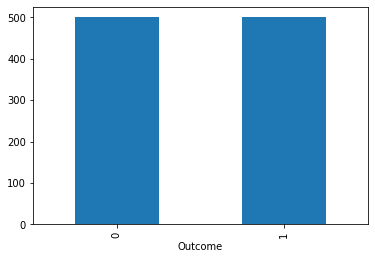

In [303]:
_ = df['Outcome'].value_counts().plot.bar()

### Attributes corelation with target

Glucose and Insulin are corellated (0.323445) since glucose is heavily corellated with target it is sensable to remove Insulin from the dataset if the model will be overfitting. Also Skin thickness and insulin are corelated (0.445345), so it is yet another indicator that insulin might affect the predictions badly, however if we were making conclusions based on the general knowlege of diabities this assumption would be counterintuitive since insulin is one of the most important chemical in the diabities, so further research is needed

In [304]:
corr = df.select_dtypes('number').corr()

corr['Outcome'].sort_values().index

Index(['BloodPressure', 'SkinThickness', 'Insulin', 'DiabetesPedigreeFunction',
       'Pregnancies', 'Age', 'BMI', 'Glucose', 'Outcome'],
      dtype='object')

<Axes: >

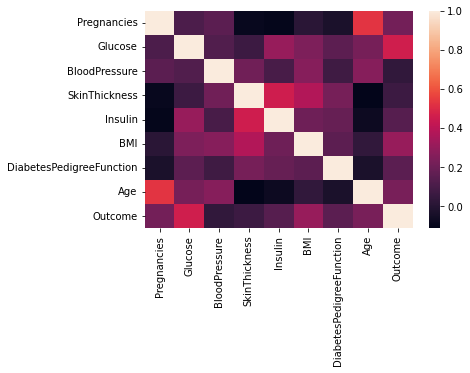

In [305]:
import seaborn as sns
%matplotlib inline

sns.heatmap(corr)

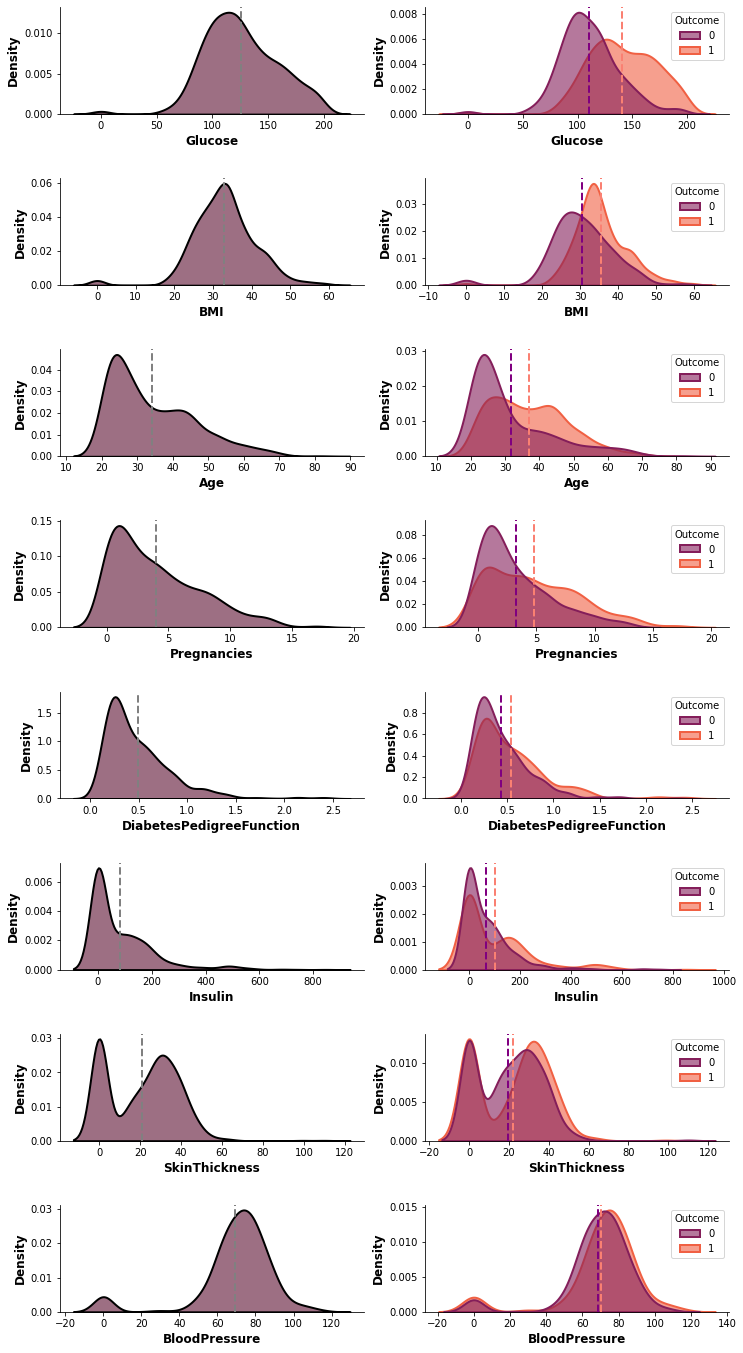

In [306]:
plotIndex = 1

columns = corr['Outcome'].sort_values(ascending = False)[1:].index

nrows, ncols = len(columns), 2 

fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize=(6*ncols, 3*nrows))

for i, col in enumerate(columns):
# for col in ['Insulin']:
    
    sns.kdeplot(df, x=col, fill=True, linewidth=2, 
                color='#5c1031', alpha=0.6, edgecolor='k',
                ax=ax[i][0])
    
    ax[i][0].axvline(df[col].mean(), color='grey', linestyle='--', linewidth=2)
    
    ax[i][0].set_xlabel(xlabel=col, fontsize=12, weight='bold')
    ax[i][0].set_ylabel(ylabel='Density', fontsize=12, weight='bold')
    sns.despine()

    sns.kdeplot(df, x=col, fill=True, hue='Outcome', 
                linewidth=2, palette='rocket', alpha=0.6, 
                ax=ax[i][1])
    
    
    ax[i][1].axvline(df[df['Outcome'] == 0][col].mean(), color='purple', linestyle='--', linewidth=2)
    ax[i][1].axvline(df[df['Outcome'] == 1][col].mean(), color='salmon', linestyle='--', linewidth=2)
    
    ax[i][1].set_xlabel(xlabel=col, fontsize=12, weight='bold')
    ax[i][1].set_ylabel(ylabel='Density', fontsize=12, weight='bold')
    sns.despine()

    
plt.subplots_adjust(hspace=0.6)    
plt.show()

### Glucose

Good tresholds for Glucose can be seen below. For analysis of better tresholds I ploted mean outcome of a current value as well as number of samples of current value. By visual analysis I've chosen [75, 118, 153]

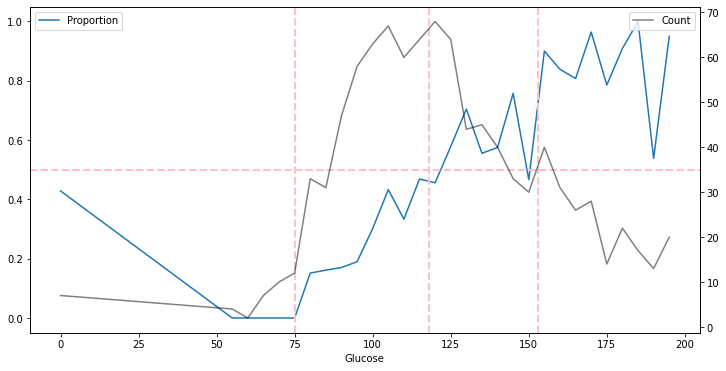

In [307]:
temp_df = df[['Glucose', 'Outcome']]

temp_df.loc[:, 'Glucose'] = (temp_df['Glucose']//5)*5


nrows, ncols = 1, 1

fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize=(12, 6))

_ = temp_df.groupby(['Glucose'])['Outcome'].mean().plot(ax=ax, label='Proportion')
ax2 = ax.twinx()
_ = (temp_df.groupby(['Glucose'])['Outcome'].count()).plot(ax=ax2, color='k', alpha=0.5, label='Count')



_ = ax.axvline(75, color='pink', linestyle='--', linewidth=2)
_ = ax.axvline(118, color='pink', linestyle='--', linewidth=2)
_ = ax.axvline(153, color='pink', linestyle='--', linewidth=2)
_ = ax.axhline(0.5, color='pink', linestyle='--', linewidth=2)

ax.legend()
ax2.legend()

custom_tresholds = {}
custom_tresholds['Glucose'] = [75, 118, 153]

### BMI

good tresholds are 24 and 40, since for values <= 24 there are small chance of diabetes, for values between 24 and 40 - medium chance, for values higher than 40 - high chance of diabeties 

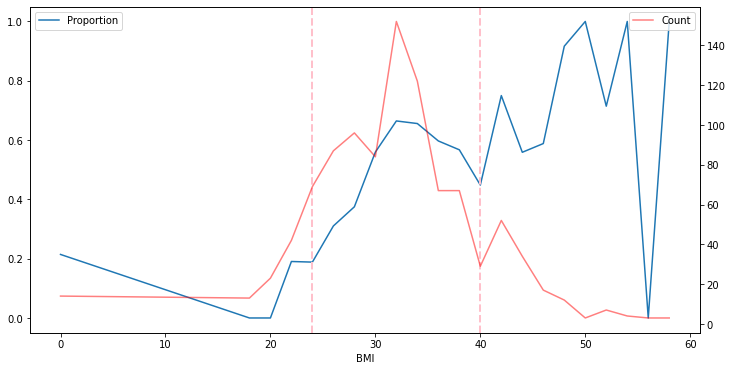

In [308]:
temp_df = df[['BMI', 'Outcome']]

temp_df.loc[:, 'BMI'] = (temp_df['BMI']//2)*2


nrows, ncols = 1, 1

fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize=(12, 6))

_ = temp_df.groupby(['BMI'])['Outcome'].mean().plot(ax=ax, label='Proportion')
ax2 = ax.twinx()
_ = (temp_df.groupby(['BMI'])['Outcome'].count()).plot(ax=ax2, color='r', alpha=0.5, label='Count')



_ = ax.axvline(40, color='pink', linestyle='--', linewidth=2)
_ = ax.axvline(24, color='pink', linestyle='--', linewidth=2)
# _ = ax.axvline(153, color='pink', linestyle='--', linewidth=2)
# _ = ax.axhline(0.5, color='pink', linestyle='--', linewidth=2)

ax.legend()
ax2.legend()

custom_tresholds['BMI'] = [24, 40, 70]

### Age

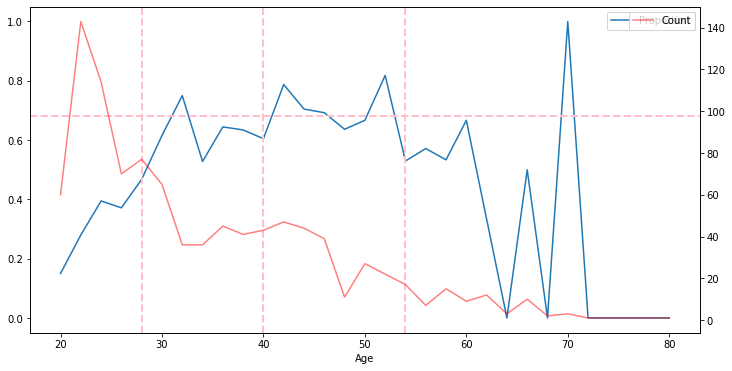

In [309]:
temp_df = df[['Age', 'Outcome']]

temp_df.loc[:, 'Age'] = (temp_df['Age']//2)*2


nrows, ncols = 1, 1

fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize=(12, 6))

_ = temp_df.groupby(['Age'])['Outcome'].mean().plot(ax=ax, label='Proportion')
ax2 = ax.twinx()
_ = (temp_df.groupby(['Age'])['Outcome'].count()).plot(ax=ax2, color='r', alpha=0.5, label='Count')



_ = ax.axvline(40, color='pink', linestyle='--', linewidth=2)
_ = ax.axvline(28, color='pink', linestyle='--', linewidth=2)
_ = ax.axvline(54, color='pink', linestyle='--', linewidth=2)
_ = ax.axhline(0.68, color='pink', linestyle='--', linewidth=2)

ax.legend()
ax2.legend()

# custom_tresholds['Age'] = [24, 40, 70]

For the remaining attributes lets for now use 25%, 50%, 75% percentile since they are less important

# Preprocessing

I've removed skinthickness and blood pressure since they are weakly correlated with target and LazyFca algorthm will take longer time to classify objects

In [310]:
useful_columns = ['Insulin', 'DiabetesPedigreeFunction', 'Pregnancies', 'Age', 'BMI', 'Glucose', 'Outcome']

df_useful = df[useful_columns]

Splitting into test and train:

In [311]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
                                                    df_useful.drop(["Outcome"], axis=1), # X
                                                    df_useful["Outcome"], # y
                                                    test_size=0.2, # доля от всех записей
                                                    random_state=777, # зерно
                                                    stratify=df_useful["Outcome"]
                                        )

In [312]:
X_train.columns

Index(['Insulin', 'DiabetesPedigreeFunction', 'Pregnancies', 'Age', 'BMI',
       'Glucose'],
      dtype='object')

Scaling:

For binarizing I use ordinal scale. The code for this scaler is in the begging of this doc

In [313]:
X_train_scaled = pd.DataFrame(index = X_train.index)
X_test_scaled = pd.DataFrame(index = X_test.index)

scaler_dict = {}

columns = ['Insulin', 'DiabetesPedigreeFunction', 'Pregnancies', 'Age', 'BMI']

for column in X_train:
    scaler_dict[column] = OrdinalScaler(column)
    if column in custom_tresholds.keys():
        scaler_dict[column].fit(X_train, custom_tresholds[column])
    else:
        scaler_dict[column].fit(X_train, [])
    scaled_data = scaler_dict[column].scale(X_train)
    scaled_data_test = scaler_dict[column].scale(X_test)
    X_train_scaled = pd.concat([X_train_scaled, scaled_data], axis=1)
    X_test_scaled = pd.concat([X_test_scaled, scaled_data_test], axis=1)
    
    
X_train_scaled.shape, X_test_scaled.shape

((800, 18), (200, 18))

Checking if scaling is correct:

(Spoiler: it is)

In [314]:
df_useful.loc[25]

Insulin                     57.000
DiabetesPedigreeFunction     1.096
Pregnancies                  1.000
Age                         32.000
BMI                         46.300
Glucose                     81.000
Outcome                      0.000
Name: 25, dtype: float64

In [315]:
X_train_scaled.loc[25]

Insulin<=0.0                                    False
Insulin<=37.0                                   False
Insulin<=135.0                                   True
DiabetesPedigreeFunction<=0.245                 False
DiabetesPedigreeFunction<=0.389                 False
DiabetesPedigreeFunction<=0.6525000000000001    False
Pregnancies<=1.0                                 True
Pregnancies<=3.0                                 True
Pregnancies<=6.0                                 True
Age<=25.0                                       False
Age<=31.0                                       False
Age<=42.0                                        True
BMI<=24                                         False
BMI<=40                                         False
BMI<=70                                          True
Glucose<=75                                     False
Glucose<=118                                     True
Glucose<=153                                     True
Name: 25, dtype: bool

# Training Lazy classificator

In [316]:
classifier = LazyClassifierFCA()
classifier.fit(X_train_scaled, y_train)

In [317]:
# from time import time

y_lazy_pred = classifier.predict(X_test_scaled)

200it [02:03,  1.63it/s]


In [318]:
def metric_keeper(name_of_model, y_test, y_pred, df=None):
    
    if df is None:
        df = pd.DataFrame(columns=[
            'accuracy', 'F1', 'TN', 'FP', 'FN', 'TP',
            'Specificity', 'Sensitivity_Recall', 'FPR', 'FDR', 'Precision'
        ])
    
    TN, FP, FN, TP = confusion_matrix(y_test, y_pred).reshape(-1,)

    Specificity = TN/(TN+FP)
    Sensitivity_Recall = TP/(FN+TP)

    accuracy = accuracy_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    # NPV = TP/(TP+FP)
    FPR = FP/(FP+TN)
    FDR = FP/(FP+TP)

    Precision = TP/(TP+FP)
    
    metric_arr = [accuracy, F1, TN, FP, FN, TP, Specificity, Sensitivity_Recall, FPR, FDR, Precision]
    df.loc[name_of_model] = metric_arr
    return df
    
    
metric_df = metric_keeper('LazyFCA (my tresholds)', y_test, y_lazy_pred)
metric_df

,accuracy,F1,TN,FP,FN,TP,Specificity,Sensitivity_Recall,FPR,FDR,Precision
LazyFCA (my tresholds),0.635,0.730627,28.0,72.0,1.0,99.0,0.28,0.99,0.72,0.421053,0.578947
DTC (my tresholds),0.825,0.832536,78.0,22.0,13.0,87.0,0.78,0.87,0.22,0.201835,0.798165
DTC numerical attributes,0.870,0.875000,83.0,17.0,9.0,91.0,0.83,0.91,0.17,0.157407,0.842593
Lazy+DCT att. 3 random,0.500,0.666667,0.0,100.0,0.0,100.0,0.00,1.00,1.00,0.500000,0.500000
Lazy+DCT att. 3 sparcly,0.535,0.682594,7.0,93.0,0.0,100.0,0.07,1.00,0.93,0.481865,0.518135
Lazy+DCT att. 3 important,0.655,0.743494,31.0,69.0,0.0,100.0,0.31,1.00,0.69,0.408284,0.591716
Lazy+DCT att. 3 shallow,0.720,0.779528,45.0,55.0,1.0,99.0,0.45,0.99,0.55,0.357143,0.642857


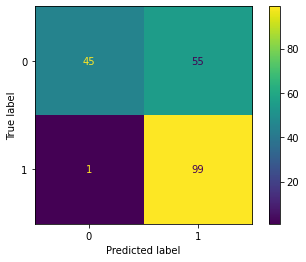

In [233]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

_ = ConfusionMatrixDisplay(confusion_matrix(y_test, y_lazy_pred)).plot()

# Training other models

In [254]:
%%time

from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],  # Function to measure split quality
    'splitter': ['best', 'random'],                # Strategy to choose the split at each node
    'max_depth': [None, 10, 20, 30, 40, 50],       # Maximum depth of the tree
    'min_samples_split': [2, 5, 10, 20],           # Minimum number of samples to split a node
    'min_samples_leaf': [1, 2, 4, 10],             # Minimum number of samples to be at a leaf node
    'max_features': ['sqrt', 'log2', None]         # Number of features to consider for the best split
}

dtc = DecisionTreeClassifier(random_state=0)

clf = GridSearchCV(dtc, param_grid, scoring="f1_macro", verbose=1, cv=4)

clf.fit(X_train_scaled, y_train)

best_model = clf.best_estimator_
best_model.fit(X_train_scaled, y_train)

y_true, y_pred = y_test, best_model.predict(X_test_scaled)

Fitting 4 folds for each of 1728 candidates, totalling 6912 fits
Wall time: 38.4 s


In [256]:
metric_df = metric_keeper('DTC (my tresholds)', y_test, y_pred, metric_df)
metric_df

,accuracy,F1,TN,FP,FN,TP,Specificity,Sensitivity_Recall,FPR,FDR,Precision
LazyFCA (my tresholds),0.720,0.779528,45.0,55.0,1.0,99.0,0.45,0.99,0.55,0.357143,0.642857
DTC (my tresholds),0.825,0.832536,78.0,22.0,13.0,87.0,0.78,0.87,0.22,0.201835,0.798165


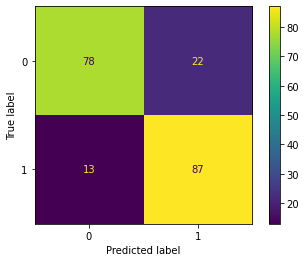

In [257]:
_ = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

## Searching for optimal tresholds using decision tree classifier and numerical attributes

Since finding a tresholds by hand is very challeging task I've decided to use tresholds that decision tree classifier (DCT) provides. It is counterintuitive to do so, since DTC can be described as stochastic version of FCA based classifiers, but I've decided to try anyway

Firstly we need to train DCT on the numerical data

In [258]:
%%time

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],  # Function to measure split quality
    'splitter': ['best', 'random'],                # Strategy to choose the split at each node
    'max_depth': [None, 10, 20, 30, 40, 50],       # Maximum depth of the tree
    'min_samples_split': [2, 5, 10, 20],           # Minimum number of samples to split a node
    'min_samples_leaf': [1, 2, 4, 10],             # Minimum number of samples to be at a leaf node
    'max_features': ['sqrt', 'log2', None]         # Number of features to consider for the best split
}


dtc = DecisionTreeClassifier(random_state=0)

clf = GridSearchCV(dtc, param_grid, scoring="f1_macro", verbose=1, cv=4)

clf.fit(X_train, y_train)

best_model = clf.best_estimator_
best_model.fit(X_train, y_train)

y_true, y_pred = y_test, best_model.predict(X_test)

Fitting 4 folds for each of 1728 candidates, totalling 6912 fits
Wall time: 38.3 s


In [259]:
metric_df = metric_keeper('DTC numerical attributes', y_test, y_pred, metric_df)
metric_df

,accuracy,F1,TN,FP,FN,TP,Specificity,Sensitivity_Recall,FPR,FDR,Precision
LazyFCA (my tresholds),0.720,0.779528,45.0,55.0,1.0,99.0,0.45,0.99,0.55,0.357143,0.642857
DTC (my tresholds),0.825,0.832536,78.0,22.0,13.0,87.0,0.78,0.87,0.22,0.201835,0.798165
DTC numerical attributes,0.870,0.875000,83.0,17.0,9.0,91.0,0.83,0.91,0.17,0.157407,0.842593


## Treshold extraction from tree

Then we need to extract all features from DCT. The DCT graph can be seen below 

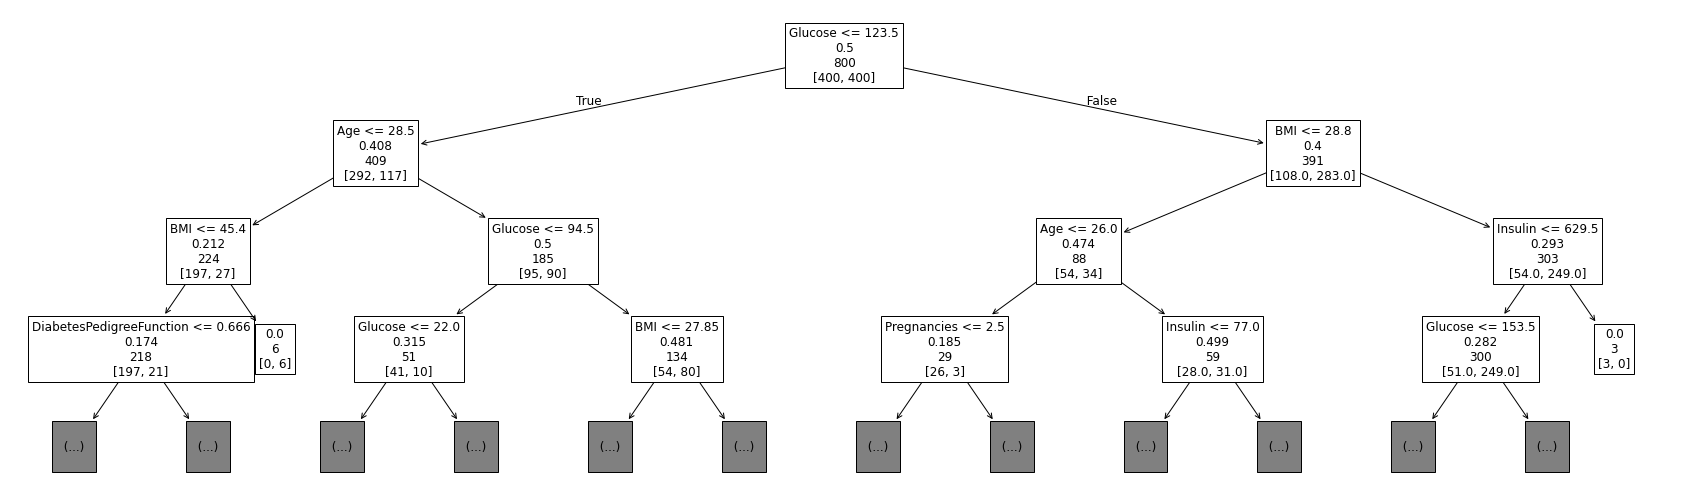

In [260]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree


nrows, ncols = 1, 1

fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize=(30, 9))

plot_tree(best_model, ax=ax, feature_names=X_train.columns, max_depth=3, label='none', fontsize=12)
plt.show()

To extract needed fetures from DCT I used code from stackoverflow [[1]](https://stackoverflow.com/questions/20224526/how-to-extract-the-decision-rules-from-scikit-learn-decision-tree). I've changed it to my needs

In [339]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    '''
        returns repeating string containing in format:
        {depth};{name};{threshold};{impurity_metric};
    '''
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    
    def recurse(node, depth):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            impurity = tree_.impurity[node]
            text ="{};{};{};".format(depth, name, threshold) 
            
            text_child1, impurity_child1 = recurse(tree_.children_left[node], depth + 1)
            text_child2, impurity_child2 = recurse(tree_.children_right[node], depth + 1)
            
            text+='{};'.format((impurity-min(impurity_child1, impurity_child2))/impurity)
            text+=text_child1
            text+=text_child2
            
            
            return text, impurity
        
        
        return '', tree_.impurity[node]
            
            
    text, _ = recurse(0, 1)
    return text

In [340]:
a = tree_to_code(best_model, feature_names=X_train.columns)
a[:50]

'1;Glucose;123.5;0.20031920251699042;2;Age;28.5;0.4'

Parcing features into dicts:

In [346]:
def treshold_extraction(text):
    text_arr = text.split(';')[:-1]
    depth = text_arr[::4]
    columns = text_arr[1::4]
    values = text_arr[2::4]
    impurities = text_arr[3::4]
    
    print(len(text_arr), len(columns), len(values), len(impurities))
    
    treshold_dict = dict()
    
    for i, col in enumerate(columns):
        treshold_dict.setdefault(col, []).append((float(values[i]), float(impurities[i]), int(depth[i])))
        
    for i in treshold_dict:
        treshold_dict[i] = list(sorted(treshold_dict[i], key=lambda x: -x[-2]*1000+x[-1]))
    
    return treshold_dict

treshold_dict = treshold_extraction(a)
treshold_dict['Age']

456 114 114 114


[(27.5, 1.0, 6),
 (51.5, 1.0, 6),
 (53.5, 1.0, 7),
 (27.5, 1.0, 8),
 (52.5, 1.0, 8),
 (44.0, 1.0, 8),
 (63.5, 1.0, 9),
 (42.5, 1.0, 11),
 (28.5, 0.6576821938392187, 6),
 (26.0, 0.6088068203896699, 3),
 (29.5, 0.5925591079696446, 7),
 (44.0, 0.5416612593755452, 6),
 (28.5, 0.4809468195660444, 2),
 (41.0, 0.35897435897435903, 8)]

In [342]:
all_tresholds = {key: np.array(value)[:, 0] for key, value in treshold_dict.items()}
all_tresholds['BMI']

array([45.39999962, 33.        , 34.04999924, 36.60000038, 34.64999962,
       32.5       ,  9.64999962, 33.5       , 24.35000038, 27.69999981,
       33.        , 34.45000076, 39.64999962, 34.85000038, 30.09999943,
       33.89999962, 32.45000076, 48.5       , 31.19999981, 28.80000019,
       27.84999943])

## 3 random tresholds from the list

First simple idea of how the resulting data can be used: choose 3 random tresholds of every attribute. Pros: it is simople, cons: it probably won't show high effectivness  

In [335]:
np.random.seed(1)

In [336]:
X_train_scaled = pd.DataFrame(index = X_train.index)
X_test_scaled = pd.DataFrame(index = X_test.index)

scaler_dict = {}

columns = ['Insulin', 'DiabetesPedigreeFunction', 'Pregnancies', 'Age', 'BMI']

for column in X_train:
    scaler_dict[column] = OrdinalScaler(column)
    if column in all_tresholds.keys():
        scaler_dict[column].fit(X_train, np.random.choice(all_tresholds[column], size=3, replace=False))
    else:
        scaler_dict[column].fit(X_train, [])
    scaled_data = scaler_dict[column].scale(X_train)
    scaled_data_test = scaler_dict[column].scale(X_test)
    X_train_scaled = pd.concat([X_train_scaled, scaled_data], axis=1)
    X_test_scaled = pd.concat([X_test_scaled, scaled_data_test], axis=1)
    
    
X_train_scaled.shape, X_test_scaled.shape

((800, 18), (200, 18))

In [337]:
classifier = LazyClassifierFCA()
classifier.fit(X_train_scaled, y_train)

In [338]:
y_lazy_pred = classifier.predict(X_test_scaled)

200it [01:59,  1.68it/s]


In [277]:
metric_df = metric_keeper('Lazy+DCT att. 3 random', y_test, y_lazy_pred, metric_df)
metric_df

,accuracy,F1,TN,FP,FN,TP,Specificity,Sensitivity_Recall,FPR,FDR,Precision
LazyFCA (my tresholds),0.720,0.779528,45.0,55.0,1.0,99.0,0.45,0.99,0.55,0.357143,0.642857
DTC (my tresholds),0.825,0.832536,78.0,22.0,13.0,87.0,0.78,0.87,0.22,0.201835,0.798165
DTC numerical attributes,0.870,0.875000,83.0,17.0,9.0,91.0,0.83,0.91,0.17,0.157407,0.842593
Lazy+DCT att. 3 random,0.500,0.666667,0.0,100.0,0.0,100.0,0.00,1.00,1.00,0.500000,0.500000


And it showed one of the worst results...

## 3 sparcly located tresholds

Second simple idea: sort tresholds from DCT and chose 3 that are the furthest from each other. If you look closely - many tresholds are located very tightly, the main idea - tresholds in small area don't boost metrics

In [278]:
ordered_by_value = {key: sorted(value, key=lambda x:-x[0]) for key, value in treshold_dict.items()}
selected_tresholds = {key: sorted(value)[::len(value)//3] for key, value in all_tresholds.items()}
selected_tresholds

{'Glucose': [22.0, 121.0, 137.0, 160.5],
 'Age': [26.0, 28.5, 44.0, 53.5],
 'BMI': [9.649999618530273, 32.45000076293945, 34.45000076293945],
 'DiabetesPedigreeFunction': [0.13999999314546585,
  0.27650000154972076,
  0.6755000054836273],
 'Pregnancies': [0.5, 2.5, 6.5],
 'Insulin': [11.0, 39.0, 150.5, 327.5]}

In [279]:
X_train_scaled = pd.DataFrame(index = X_train.index)
X_test_scaled = pd.DataFrame(index = X_test.index)

scaler_dict = {}

columns = ['Insulin', 'DiabetesPedigreeFunction', 'Pregnancies', 'Age', 'BMI']

for column in X_train:
    scaler_dict[column] = OrdinalScaler(column)
    if column in selected_tresholds.keys():
        scaler_dict[column].fit(X_train, selected_tresholds[column])
    else:
        scaler_dict[column].fit(X_train, [])
    scaled_data = scaler_dict[column].scale(X_train)
    scaled_data_test = scaler_dict[column].scale(X_test)
    X_train_scaled = pd.concat([X_train_scaled, scaled_data], axis=1)
    X_test_scaled = pd.concat([X_test_scaled, scaled_data_test], axis=1)
    
X_train_scaled.shape, X_test_scaled.shape

((800, 21), (200, 21))

In [280]:
classifier = LazyClassifierFCA()
classifier.fit(X_train_scaled, y_train)

In [281]:
y_lazy_pred = classifier.predict(X_test_scaled)

200it [02:00,  1.65it/s]


In [282]:
metric_df = metric_keeper('Lazy+DCT att. 3 sparcly', y_test, y_lazy_pred, metric_df)
metric_df

,accuracy,F1,TN,FP,FN,TP,Specificity,Sensitivity_Recall,FPR,FDR,Precision
LazyFCA (my tresholds),0.720,0.779528,45.0,55.0,1.0,99.0,0.45,0.99,0.55,0.357143,0.642857
DTC (my tresholds),0.825,0.832536,78.0,22.0,13.0,87.0,0.78,0.87,0.22,0.201835,0.798165
DTC numerical attributes,0.870,0.875000,83.0,17.0,9.0,91.0,0.83,0.91,0.17,0.157407,0.842593
Lazy+DCT att. 3 random,0.500,0.666667,0.0,100.0,0.0,100.0,0.00,1.00,1.00,0.500000,0.500000
Lazy+DCT att. 3 sparcly,0.535,0.682594,7.0,93.0,0.0,100.0,0.07,1.00,0.93,0.481865,0.518135


Better, but still worse than my tresholds

## 3 Most important tresholds

Third idea: DTCs use impurity metrics as measure of how good the division in the nodes are. I propose (and maybe I am terribly wrong in my assuption, I'm sorry) to use metric:

$metric = \frac{current\_impurity - min(left\_child\_impurity, right\_child\_impurity)}{current\_impurity}$

As a measure of importance of currecnt treshold. I will explain why I used this metric in my final presentation, if it will give some good results. By this measure we can sort tresholds and choose the most important

In [356]:
ordered_by_impurity = {key: np.array(value)[-3:, 0] for key, value in treshold_dict.items()}
ordered_by_impurity

{'Glucose': array([125.5, 127.5, 123.5]),
 'Age': array([44. , 28.5, 41. ]),
 'BMI': array([31.19999981, 28.80000019, 27.84999943]),
 'DiabetesPedigreeFunction': array([0.241     , 0.31199999, 0.2205    ]),
 'Pregnancies': array([ 2.5,  9.5, 10.5]),
 'Insulin': array([ 77., 199., 289.])}

In [357]:
X_train_scaled = pd.DataFrame(index = X_train.index)
X_test_scaled = pd.DataFrame(index = X_test.index)

scaler_dict = {}

columns = ['Insulin', 'DiabetesPedigreeFunction', 'Pregnancies', 'Age', 'BMI']

for column in X_train:
    scaler_dict[column] = OrdinalScaler(column)
    if column in ordered_by_impurity.keys():
        scaler_dict[column].fit(X_train, ordered_by_impurity[column])
    else:
        scaler_dict[column].fit(X_train, [])
    scaled_data = scaler_dict[column].scale(X_train)
    scaled_data_test = scaler_dict[column].scale(X_test)
    X_train_scaled = pd.concat([X_train_scaled, scaled_data], axis=1)
    X_test_scaled = pd.concat([X_test_scaled, scaled_data_test], axis=1)
    
X_train_scaled.shape, X_test_scaled.shape

((800, 18), (200, 18))

In [352]:
classifier = LazyClassifierFCA()
classifier.fit(X_train_scaled, y_train)

In [353]:
y_lazy_pred = classifier.predict(X_test_scaled)

200it [02:01,  1.65it/s]


In [361]:
metric_df = metric_keeper('Lazy+DCT att. 3 important', y_test, y_lazy_pred, metric_df)
metric_df

,accuracy,F1,TN,FP,FN,TP,Specificity,Sensitivity_Recall,FPR,FDR,Precision
LazyFCA (my tresholds),0.635,0.730627,28.0,72.0,1.0,99.0,0.28,0.99,0.72,0.421053,0.578947
DTC (my tresholds),0.825,0.832536,78.0,22.0,13.0,87.0,0.78,0.87,0.22,0.201835,0.798165
DTC numerical attributes,0.870,0.875000,83.0,17.0,9.0,91.0,0.83,0.91,0.17,0.157407,0.842593
Lazy+DCT att. 3 random,0.500,0.666667,0.0,100.0,0.0,100.0,0.00,1.00,1.00,0.500000,0.500000
Lazy+DCT att. 3 sparcly,0.535,0.682594,7.0,93.0,0.0,100.0,0.07,1.00,0.93,0.481865,0.518135
Lazy+DCT att. 3 important,0.665,0.743295,36.0,64.0,3.0,97.0,0.36,0.97,0.64,0.397516,0.602484
Lazy+DCT att. 3 shallow,0.735,0.787149,49.0,51.0,2.0,98.0,0.49,0.98,0.51,0.342282,0.657718
Lazy+DCT att. 5 shallow,0.775,0.811715,58.0,42.0,3.0,97.0,0.58,0.97,0.42,0.302158,0.697842


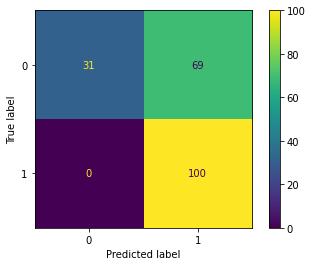

In [288]:
_ = ConfusionMatrixDisplay(confusion_matrix(y_test, y_lazy_pred)).plot()

Better! Even better than my tresholds, good sign

## 3 Ordered by depth

The final idea that I have - is to order tresholds by depth and choose the most shallow ones, since they probably have the most powerful divisions

In [320]:
ordered_by_depth = {key: np.array(sorted(value, key=lambda x: -x[-1]))[-3:, 0] for key, value in treshold_dict.items()}
ordered_by_depth

{'Glucose': array([153.5,  94.5, 123.5]),
 'Age': array([44. , 26. , 28.5]),
 'BMI': array([27.84999943, 45.39999962, 28.80000019]),
 'DiabetesPedigreeFunction': array([0.31199999, 0.2205    , 0.66600001]),
 'Pregnancies': array([11.5,  9.5,  2.5]),
 'Insulin': array([327.5,  77. , 629.5])}

In [321]:
X_train_scaled = pd.DataFrame(index = X_train.index)
X_test_scaled = pd.DataFrame(index = X_test.index)

scaler_dict = {}

columns = ['Insulin', 'DiabetesPedigreeFunction', 'Pregnancies', 'Age', 'BMI']

for column in X_train:
    scaler_dict[column] = OrdinalScaler(column)
    if column in ordered_by_impurity.keys():
        scaler_dict[column].fit(X_train, ordered_by_depth[column])
    else:
        scaler_dict[column].fit(X_train, [])
    scaled_data = scaler_dict[column].scale(X_train)
    scaled_data_test = scaler_dict[column].scale(X_test)
    X_train_scaled = pd.concat([X_train_scaled, scaled_data], axis=1)
    X_test_scaled = pd.concat([X_test_scaled, scaled_data_test], axis=1)
    
X_train_scaled.shape, X_test_scaled.shape

((800, 18), (200, 18))

In [322]:
classifier = LazyClassifierFCA()
classifier.fit(X_train_scaled, y_train)

In [323]:
y_lazy_pred = classifier.predict(X_test_scaled)

200it [02:00,  1.65it/s]


In [324]:
metric_df = metric_keeper('Lazy+DCT att. 3 shallow', y_test, y_lazy_pred, metric_df)
metric_df

,accuracy,F1,TN,FP,FN,TP,Specificity,Sensitivity_Recall,FPR,FDR,Precision
LazyFCA (my tresholds),0.635,0.730627,28.0,72.0,1.0,99.0,0.28,0.99,0.72,0.421053,0.578947
DTC (my tresholds),0.825,0.832536,78.0,22.0,13.0,87.0,0.78,0.87,0.22,0.201835,0.798165
DTC numerical attributes,0.870,0.875000,83.0,17.0,9.0,91.0,0.83,0.91,0.17,0.157407,0.842593
Lazy+DCT att. 3 random,0.500,0.666667,0.0,100.0,0.0,100.0,0.00,1.00,1.00,0.500000,0.500000
Lazy+DCT att. 3 sparcly,0.535,0.682594,7.0,93.0,0.0,100.0,0.07,1.00,0.93,0.481865,0.518135
Lazy+DCT att. 3 important,0.655,0.743494,31.0,69.0,0.0,100.0,0.31,1.00,0.69,0.408284,0.591716
Lazy+DCT att. 3 shallow,0.735,0.787149,49.0,51.0,2.0,98.0,0.49,0.98,0.51,0.342282,0.657718


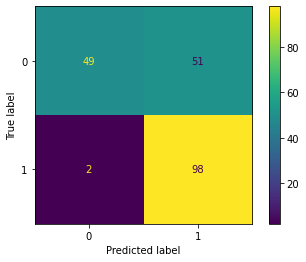

In [325]:
_ = ConfusionMatrixDisplay(confusion_matrix(y_test, y_lazy_pred)).plot()

Good result, I think this idea can be developed further

## 5 Ordered by depth

Just using more tresholds

In [326]:
ordered_by_depth = {key: np.array(sorted(value, key=lambda x: -x[-1]))[-5:, 0] for key, value in treshold_dict.items()}
ordered_by_depth

{'Glucose': array([111.5,  22. , 153.5,  94.5, 123.5]),
 'Age': array([27.5, 51.5, 44. , 26. , 28.5]),
 'BMI': array([ 9.64999962, 24.35000038, 27.84999943, 45.39999962, 28.80000019]),
 'DiabetesPedigreeFunction': array([1.13099998, 0.162     , 0.31199999, 0.2205    , 0.66600001]),
 'Pregnancies': array([ 0.5,  2.5, 11.5,  9.5,  2.5]),
 'Insulin': array([120. ,  25. , 327.5,  77. , 629.5])}

In [327]:
X_train_scaled = pd.DataFrame(index = X_train.index)
X_test_scaled = pd.DataFrame(index = X_test.index)

scaler_dict = {}

columns = ['Insulin', 'DiabetesPedigreeFunction', 'Pregnancies', 'Age', 'BMI']

for column in X_train:
    scaler_dict[column] = OrdinalScaler(column)
    if column in ordered_by_impurity.keys():
        scaler_dict[column].fit(X_train, ordered_by_depth[column])
    else:
        scaler_dict[column].fit(X_train, [])
    scaled_data = scaler_dict[column].scale(X_train)
    scaled_data_test = scaler_dict[column].scale(X_test)
    X_train_scaled = pd.concat([X_train_scaled, scaled_data], axis=1)
    X_test_scaled = pd.concat([X_test_scaled, scaled_data_test], axis=1)
    
X_train_scaled.shape, X_test_scaled.shape

((800, 30), (200, 30))

In [328]:
classifier = LazyClassifierFCA()
classifier.fit(X_train_scaled, y_train)

In [329]:
y_lazy_pred = classifier.predict(X_test_scaled)

200it [01:59,  1.68it/s]


In [330]:
metric_df = metric_keeper('Lazy+DCT att. 5 shallow', y_test, y_lazy_pred, metric_df)
metric_df

,accuracy,F1,TN,FP,FN,TP,Specificity,Sensitivity_Recall,FPR,FDR,Precision
LazyFCA (my tresholds),0.635,0.730627,28.0,72.0,1.0,99.0,0.28,0.99,0.72,0.421053,0.578947
DTC (my tresholds),0.825,0.832536,78.0,22.0,13.0,87.0,0.78,0.87,0.22,0.201835,0.798165
DTC numerical attributes,0.870,0.875000,83.0,17.0,9.0,91.0,0.83,0.91,0.17,0.157407,0.842593
Lazy+DCT att. 3 random,0.500,0.666667,0.0,100.0,0.0,100.0,0.00,1.00,1.00,0.500000,0.500000
Lazy+DCT att. 3 sparcly,0.535,0.682594,7.0,93.0,0.0,100.0,0.07,1.00,0.93,0.481865,0.518135
Lazy+DCT att. 3 important,0.655,0.743494,31.0,69.0,0.0,100.0,0.31,1.00,0.69,0.408284,0.591716
Lazy+DCT att. 3 shallow,0.735,0.787149,49.0,51.0,2.0,98.0,0.49,0.98,0.51,0.342282,0.657718
Lazy+DCT att. 5 shallow,0.775,0.811715,58.0,42.0,3.0,97.0,0.58,0.97,0.42,0.302158,0.697842


Better